# Implement a neural network for m-samples, n-features as we discussed in class (both FP and BP) and for N layers in the hidden layer. Split the data (you can use the log. reg. data or any other one) and train your network with 70% of the data. Use 15% for validation  and test your network with the remaining 15% data. Report the evaluation metrics for varying number of layers in the network. Plot the training loss curves.

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [109]:
# Load the data
df = pd.read_csv('Logistic_regression_ls.csv')
X = df[['x1', 'x2']].values.T  # Shape: (n_x, m)
Y = df['label'].values.reshape(1, -1)  # Shape: (1, m)

# Split the data
X_train, X_temp, Y_train, Y_temp = train_test_split(X.T, Y.T, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)
# print(Y_test)

In [110]:
# print(Y_train)
# One hot encoding for labels
def one_hot_enc(labels, dimension=2):
    # Creating an array of zeros of shape (number of labels, number of categories)
    one_hot_labels = np.zeros((len(labels), dimension))

    one_hot_labels[np.arange(len(labels)), labels] = 1
    return one_hot_labels

# Flatten Y_train,val,test to make it a 1D array
Y_train_flat = Y_train.ravel()
Y_val_flat = Y_val.ravel()
Y_test_flat = Y_test.ravel()

# print(Y_train_flat)

# one-hot encoding to the datasets
Y_train_encode = one_hot_enc(Y_train_flat)
Y_val_encode = one_hot_enc(Y_val_flat)
Y_test_encode = one_hot_enc(Y_test_flat)

# print(Y_train_encode)  # for verifying
# print(Y_val_encode) #verifying

In [111]:
#all necessary functions::
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    sig = sigmoid(x)
    return sig * (1 - sig)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def cross_entropy(y_hat, y):
    m = y.shape[0]
    logyhat = np.log(y_hat)
    loss = -np.sum(y * logyhat) / m
    return loss

activation_function = {
    "sigmoid": sigmoid
}

activation_derivative = {
    "sigmoid": sigmoid_deriv
}


In [112]:
class NeuralNetwork:
    #initialize the network with construtor
    def __init__(self, layer_sizes, activation_func="sigmoid", weight_init="random"):
        self.layer_sizes = layer_sizes
        self.activation_func = activation_func
        self.weights, self.biases = self.init_network(layer_sizes, weight_init)

    #initializing function
    def init_network(self, layer_sizes, weight_init):
        weights = []
        biases = []
        # i = 0 to L-1; here len(self.layer_sizes) = L+1(input_layer+hidden_layers+output_layer)
        for i in range(len(layer_sizes) - 1):
            stddev = 0.1  # standard deviation for random initialization
            weight = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * stddev
            bias = np.zeros((1, layer_sizes[i + 1]))
            weights.append(weight)
            biases.append(bias)
        return weights, biases


    #forward propagation
    def feedforward(self, X):
        a = {}
        h = {"h0": X}
        # i = 1 to L; here len(self.layer_sizes) = L+1(input_layer+hidden_layers+output_layer)
        for i in range(1, len(self.layer_sizes)):
            h_previous = h["h" + str(i-1)]   #input layer(data point)
            a_current = np.dot(h_previous, self.weights[i-1]) + self.biases[i-1]
            a["a" + str(i)] = a_current
            if i == len(self.layer_sizes) - 1:  # for output layer
                h_current = softmax(a_current)
            else:
                h_current = activation_function[self.activation_func](a_current)   #sigmoid(a_current)
            h["h" + str(i)] = h_current
        y_hat = h["h" + str(len(self.layer_sizes) - 1)]
        return h, a, y_hat

In [113]:
# for backward propagation and the optimizers
class backward_optimizer(NeuralNetwork):
    #backward propagation
    def backward(self, h, a, y, y_hat):
        number_hidden = len(self.layer_sizes) - 2  #excluding input and output layers
        grad = self.init_grad()

        #derivative of cross-entropy w.r.t softmax function
        da = y_hat - y

        # i = L to 1; here len(self.layer_sizes) = L+1(input_layer+hidden_layers+output_layer)
        for i in reversed(range(1, len(self.layer_sizes))):
            grad["dW" + str(i)] = np.dot(h["h" + str(i-1)].T, da) / y.shape[0]   #for normalizing, dividing by y.shape[0]
            grad["db" + str(i)] = np.sum(da, axis=0, keepdims=True) / y.shape[0]
            if i > 1:  #no need to calculate derivatives after the first hidden layer
                dh_previous = np.dot(da, self.weights[i-1].T)
                da = dh_previous * activation_derivative[self.activation_func](a["a" + str(i-1)])
        return grad


    #gradient initializing
    def init_grad(self):
        grad = {}
        # i = 1 to L; here len(self.layer_sizes) = L+1(input_layer+hidden_layers+output_layer)
        for i in range(1, len(self.layer_sizes)):
            grad["dW" + str(i)] = np.zeros_like(self.weights[i-1])   #initializing dw1 with W1 having all zeros
            grad["db" + str(i)] = np.zeros_like(self.biases[i-1])    #initializing db1 with b1 having all zeros
        return grad


    #loss_accuracy function
    def loss_accuracy(self, X, y):

        h, a, y_hat = self.feedforward(X)
        loss = cross_entropy(y_hat, y)

        predictions = np.argmax(y_hat, axis=1)   #finding indices of max element in each row of y_hat
        labels = np.argmax(y, axis=1)            #finding indices of max element in each row of y
        accuracy = np.mean(predictions == labels) #mean of the above two

        return loss, accuracy
    
    
    # gradient descent method
    def gradient_descent(self, X_train, Y_train,X_val, Y_val_encode, max_epochs, eta, batch_size):
        train_datapoints = X_train.shape[0]
        train_losses = []
        val_losses = []
        for epoch in range(max_epochs):
            for start in range(0, train_datapoints, batch_size):
                end = min(start + batch_size, train_datapoints)
                X_batch = X_train[start:end]
                Y_batch = Y_train[start:end]

                # Forward prop
                h, a, y_hat = self.feedforward(X_batch)
                # print(h['h0'])

                # Backward prop
                grad = self.backward(h, a, Y_batch, y_hat)

                # Update weights and biases with gradient descent rule
                for i in range(1, len(self.layer_sizes)):
                    self.weights[i-1] -= eta * (grad["dW" + str(i)])
                    self.biases[i-1] -= eta * grad["db" + str(i)]

            # printing loss and accuracy at the end of each epoch
            loss, accuracy = self.loss_accuracy(X_train, Y_train)
            train_losses.append(loss)
            print(f"End of Epoch {epoch}, Training Loss: {loss}, Training Accuracy: {accuracy*100}")

            # printing loss and accuracy on the validation dataset
            val_loss, val_accuracy = self.loss_accuracy(X_val, Y_val_encode)
            val_losses.append(val_loss)
            print(f"End of Epoch {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy*100}")
        return train_losses,val_losses
           


    #for training the model by the optimizers
    def train(self,optimizer,max_epochs, eta,batch_size):
        if optimizer == 'grad':
          self.gradient_descent(X_train, Y_train_encode,X_val, Y_val_encode, max_epochs, eta,batch_size)
        
    # for predicting the corresponding labels of X_test
    def predict(self, X):
        _, _, y_hat = self.feedforward(X)
        # print(y_hat.shape)
        predictions = np.argmax(y_hat, axis=1)  #probabilities to class labels
        # print(predictions.shape)
        return predictions


In [144]:
layer_sizes = [2, 5, 2]

# initializing the model
model = backward_optimizer(layer_sizes, activation_func="sigmoid", weight_init="random")


# X_train, Y_train_encode are training data and labels
#model training by grad_descent
train_losses,val_losses = model.gradient_descent(X_train, Y_train_encode,X_val,Y_val_encode, eta=0.01, max_epochs=10, batch_size=1)

End of Epoch 0, Training Loss: 0.6210214416574813, Training Accuracy: 53.42857142857142
End of Epoch 0, Validation Loss: 0.6195548791168345, Validation Accuracy: 54.666666666666664
End of Epoch 1, Training Loss: 0.5531343727382658, Training Accuracy: 79.71428571428572
End of Epoch 1, Validation Loss: 0.5512460403758719, Validation Accuracy: 78.66666666666666
End of Epoch 2, Training Loss: 0.4877246018421012, Training Accuracy: 92.57142857142857
End of Epoch 2, Validation Loss: 0.4856267297477087, Validation Accuracy: 93.33333333333333
End of Epoch 3, Training Loss: 0.42316326383017544, Training Accuracy: 96.28571428571429
End of Epoch 3, Validation Loss: 0.42113274740725276, Validation Accuracy: 96.0
End of Epoch 4, Training Loss: 0.3611620316151999, Training Accuracy: 97.42857142857143
End of Epoch 4, Validation Loss: 0.35942285515722877, Validation Accuracy: 98.66666666666667
End of Epoch 5, Training Loss: 0.3052095529960124, Training Accuracy: 98.57142857142858
End of Epoch 5, Valid

In [135]:

# initializing the model
model_forward = NeuralNetwork(layer_sizes, activation_func="sigmoid", weight_init="random")
_,_,y_hat = model_forward.feedforward(X_train)

better_model = backward_optimizer(layer_sizes, "sigmoid", "random")
better_model.train("grad",max_epochs = 10,eta = 0.01,batch_size = 1)

y_predict = better_model.predict(X_test)
print(y_predict)
true_labels = np.argmax(Y_test_encode, axis=1)
print(true_labels)

End of Epoch 0, Training Loss: 0.6260946607085388, Training Accuracy: 56.00000000000001
End of Epoch 0, Validation Loss: 0.6258317240077292, Validation Accuracy: 57.333333333333336
End of Epoch 1, Training Loss: 0.5568816171149203, Training Accuracy: 76.85714285714286
End of Epoch 1, Validation Loss: 0.5565315928061263, Validation Accuracy: 76.0
End of Epoch 2, Training Loss: 0.48763820368758487, Training Accuracy: 89.71428571428571
End of Epoch 2, Validation Loss: 0.48750967259517913, Validation Accuracy: 89.33333333333333
End of Epoch 3, Training Loss: 0.4218768642008757, Training Accuracy: 95.42857142857143
End of Epoch 3, Validation Loss: 0.42205614335660924, Validation Accuracy: 97.33333333333334
End of Epoch 4, Training Loss: 0.36073867900497225, Training Accuracy: 96.57142857142857
End of Epoch 4, Validation Loss: 0.3611272843784881, Validation Accuracy: 98.66666666666667
End of Epoch 5, Training Loss: 0.30573843210655655, Training Accuracy: 98.57142857142858
End of Epoch 5, Val

End of Epoch 0, Training Loss: 0.14762403014581146, Training Accuracy: 100.0
End of Epoch 0, Validation Loss: 0.14700589521182209, Validation Accuracy: 100.0
End of Epoch 1, Training Loss: 0.1287473287385492, Training Accuracy: 100.0
End of Epoch 1, Validation Loss: 0.1280973362587053, Validation Accuracy: 100.0
End of Epoch 2, Training Loss: 0.11339278113816285, Training Accuracy: 100.0
End of Epoch 2, Validation Loss: 0.1127007357598912, Validation Accuracy: 100.0
End of Epoch 3, Training Loss: 0.10080368213694468, Training Accuracy: 100.0
End of Epoch 3, Validation Loss: 0.10006838896509208, Validation Accuracy: 100.0
End of Epoch 4, Training Loss: 0.09038794459160084, Training Accuracy: 100.0
End of Epoch 4, Validation Loss: 0.08961232814835313, Validation Accuracy: 100.0


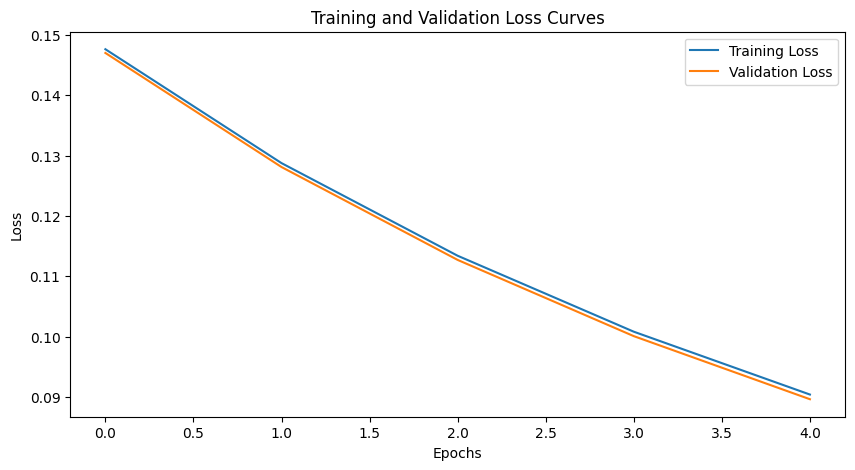

In [136]:
import matplotlib.pyplot as plt

# Train the model
train_losses, val_losses = model.gradient_descent(X_train, Y_train_encode, X_val, Y_val_encode, max_epochs=5, eta=0.01, batch_size=1)

# Plotting the training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [96]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_metrics(predictions, labels):
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='macro')
    recall = recall_score(labels, predictions, average='macro')
    f1 = f1_score(labels, predictions, average='macro')
    return accuracy, precision, recall, f1


In [97]:
def run_experiment(layer_sizes, X_train, Y_train, X_val, Y_val, X_test, Y_test, epochs=10, eta=0.01, batch_size=32):
    # Initialize model
    model = backward_optimizer(layer_sizes, activation_func="sigmoid", weight_init="random")
    
    # Train model
    train_losses, val_losses = model.gradient_descent(X_train, Y_train, X_val, Y_val, epochs, eta, batch_size)
    
    # Evaluate model on test set
    test_predictions = model.predict(X_test)
    test_labels = np.argmax(Y_test, axis=1)
    accuracy, precision, recall, f1 = evaluate_metrics(test_predictions, test_labels)
    
    # Return results and losses for plotting
    return (train_losses, val_losses, accuracy, precision, recall, f1)


In [141]:
configurations = [
    [2, 2],          # No hidden layer
    [2, 5, 2],      # One hidden layer
    [2, 5, 5, 2],  # Two hidden layers
    [2, 5, 5, 5, 2],  # Three hidden layers
    [2, 5, 5, 5, 5, 2],  # Four hidden layers
    [2, 5, 5, 5, 5, 5, 2],  # Five hidden layers
]

End of Epoch 0, Training Loss: 0.39328563438995057, Training Accuracy: 74.28571428571429
End of Epoch 0, Validation Loss: 0.3912232390212118, Validation Accuracy: 74.66666666666667
End of Epoch 1, Training Loss: 0.2846681731833881, Training Accuracy: 92.85714285714286
End of Epoch 1, Validation Loss: 0.2828538792303123, Validation Accuracy: 94.66666666666667
End of Epoch 2, Training Loss: 0.22204789468220862, Training Accuracy: 97.42857142857143
End of Epoch 2, Validation Loss: 0.22063694826008087, Validation Accuracy: 98.66666666666667
End of Epoch 3, Training Loss: 0.18232299379204558, Training Accuracy: 98.28571428571429
End of Epoch 3, Validation Loss: 0.18123546422430958, Validation Accuracy: 98.66666666666667
End of Epoch 4, Training Loss: 0.155117244466971, Training Accuracy: 99.14285714285714
End of Epoch 4, Validation Loss: 0.15425673463063092, Validation Accuracy: 98.66666666666667
End of Epoch 5, Training Loss: 0.13537568724181068, Training Accuracy: 99.42857142857143
End of

End of Epoch 22, Training Loss: 0.04976276401591353, Training Accuracy: 100.0
End of Epoch 22, Validation Loss: 0.04878097257444208, Validation Accuracy: 100.0
End of Epoch 23, Training Loss: 0.04699972687413485, Training Accuracy: 100.0
End of Epoch 23, Validation Loss: 0.04600359633918503, Validation Accuracy: 100.0
End of Epoch 24, Training Loss: 0.04451742383294495, Training Accuracy: 100.0
End of Epoch 24, Validation Loss: 0.04350780318816959, Validation Accuracy: 100.0
End of Epoch 25, Training Loss: 0.04227730573257453, Training Accuracy: 100.0
End of Epoch 25, Validation Loss: 0.0412548240347027, Validation Accuracy: 100.0
End of Epoch 26, Training Loss: 0.04024727371887203, Training Accuracy: 100.0
End of Epoch 26, Validation Loss: 0.03921239021720319, Validation Accuracy: 100.0
End of Epoch 27, Training Loss: 0.0384004327545971, Training Accuracy: 100.0
End of Epoch 27, Validation Loss: 0.03735347759406586, Validation Accuracy: 100.0
End of Epoch 28, Training Loss: 0.03671411

End of Epoch 11, Training Loss: 0.6943517041514131, Training Accuracy: 51.714285714285715
End of Epoch 11, Validation Loss: 0.6938114197044213, Validation Accuracy: 52.0
End of Epoch 12, Training Loss: 0.6943472871611168, Training Accuracy: 51.714285714285715
End of Epoch 12, Validation Loss: 0.6938073904511441, Validation Accuracy: 52.0
End of Epoch 13, Training Loss: 0.6943428767795005, Training Accuracy: 51.714285714285715
End of Epoch 13, Validation Loss: 0.6938033672254731, Validation Accuracy: 52.0
End of Epoch 14, Training Loss: 0.6943384728884522, Training Accuracy: 51.714285714285715
End of Epoch 14, Validation Loss: 0.6937993499056995, Validation Accuracy: 52.0
End of Epoch 15, Training Loss: 0.6943340753667882, Training Accuracy: 51.714285714285715
End of Epoch 15, Validation Loss: 0.6937953383670508, Validation Accuracy: 52.0
End of Epoch 16, Training Loss: 0.6943296840901564, Training Accuracy: 51.714285714285715
End of Epoch 16, Validation Loss: 0.693791332481593, Validat

C:\Users\Partha Sakha Paul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


End of Epoch 1, Training Loss: 0.6943134583326143, Training Accuracy: 51.714285714285715
End of Epoch 1, Validation Loss: 0.6937792894312425, Validation Accuracy: 52.0
End of Epoch 2, Training Loss: 0.6943110638952302, Training Accuracy: 51.714285714285715
End of Epoch 2, Validation Loss: 0.6937771221192398, Validation Accuracy: 52.0
End of Epoch 3, Training Loss: 0.6943070547525915, Training Accuracy: 51.714285714285715
End of Epoch 3, Validation Loss: 0.693773497039111, Validation Accuracy: 52.0
End of Epoch 4, Training Loss: 0.6943030249402907, Training Accuracy: 51.714285714285715
End of Epoch 4, Validation Loss: 0.6937698537556285, Validation Accuracy: 52.0
End of Epoch 5, Training Loss: 0.6942990055220206, Training Accuracy: 51.714285714285715
End of Epoch 5, Validation Loss: 0.6937662203173999, Validation Accuracy: 52.0
End of Epoch 6, Training Loss: 0.694294997104722, Training Accuracy: 51.714285714285715
End of Epoch 6, Validation Loss: 0.6937625972702371, Validation Accuracy:

C:\Users\Partha Sakha Paul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


End of Epoch 1, Training Loss: 0.6945637750777852, Training Accuracy: 51.714285714285715
End of Epoch 1, Validation Loss: 0.6940053857306211, Validation Accuracy: 52.0
End of Epoch 2, Training Loss: 0.6945593821070443, Training Accuracy: 51.714285714285715
End of Epoch 2, Validation Loss: 0.6940013906302727, Validation Accuracy: 52.0
End of Epoch 3, Training Loss: 0.6945548218650824, Training Accuracy: 51.714285714285715
End of Epoch 3, Validation Loss: 0.6939972438705001, Validation Accuracy: 52.0
End of Epoch 4, Training Loss: 0.6945502694556743, Training Accuracy: 51.714285714285715
End of Epoch 4, Validation Loss: 0.6939931047030189, Validation Accuracy: 52.0
End of Epoch 5, Training Loss: 0.6945457273037224, Training Accuracy: 51.714285714285715
End of Epoch 5, Validation Loss: 0.693988975331405, Validation Accuracy: 52.0
End of Epoch 6, Training Loss: 0.6945411954605438, Training Accuracy: 51.714285714285715
End of Epoch 6, Validation Loss: 0.6939848558007313, Validation Accuracy

C:\Users\Partha Sakha Paul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


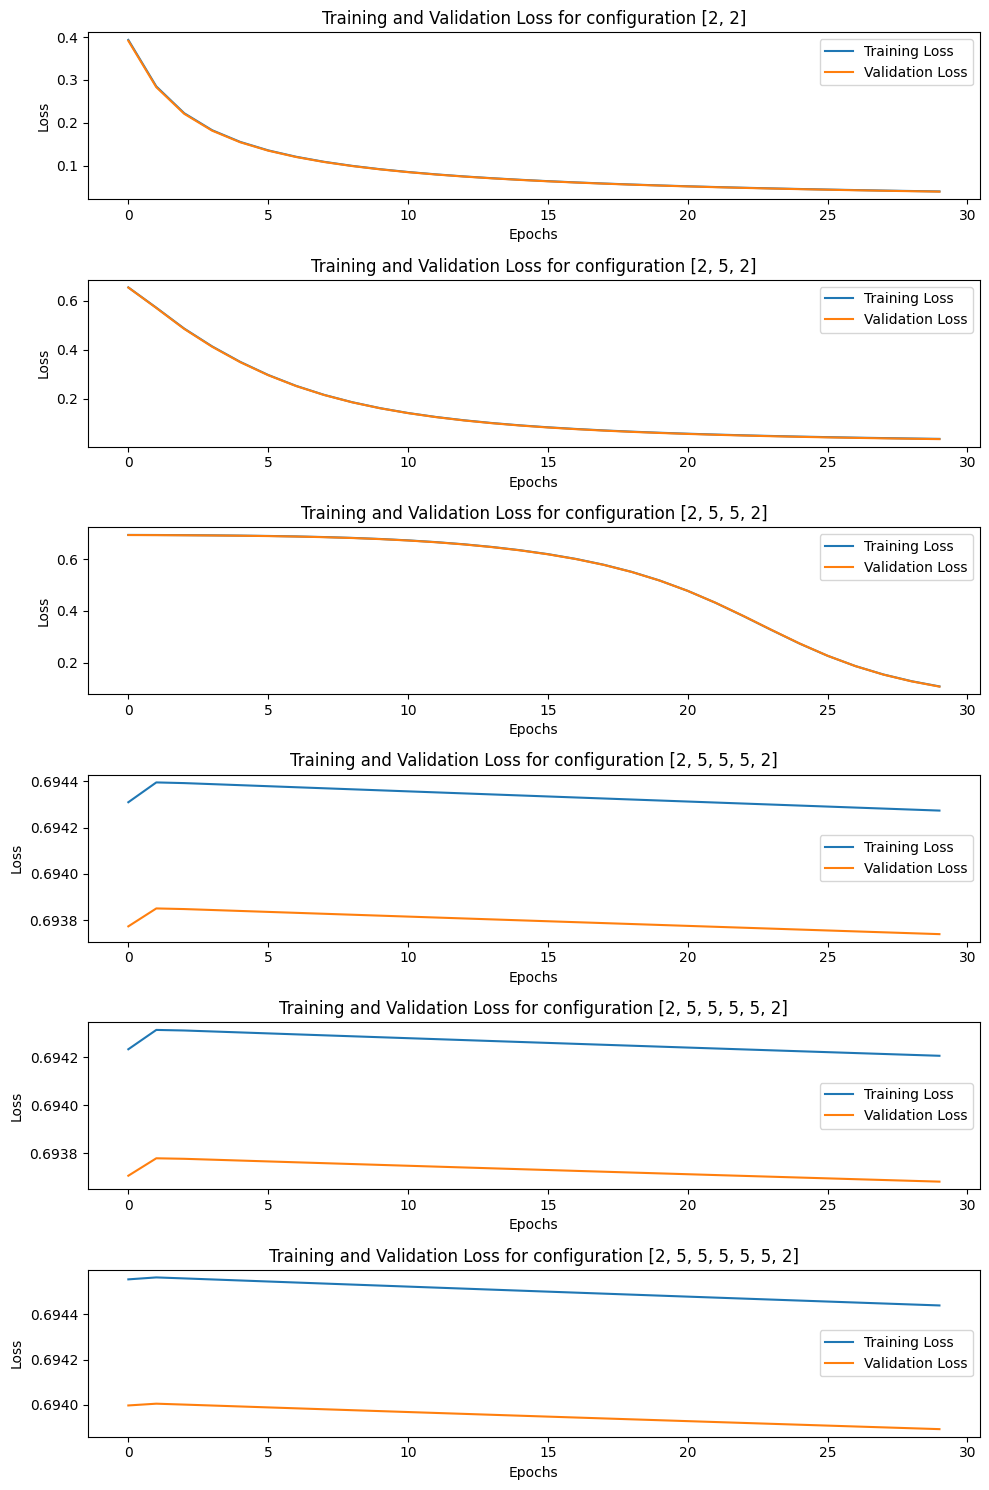

In [142]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(configurations), 1, figsize=(10, 15))

for i, layers in enumerate(configurations):
    train_losses, val_losses, acc, prec, rec, f1 = run_experiment(
        layers, X_train, Y_train_encode, X_val, Y_val_encode, X_test, Y_test_encode, epochs=30, eta=0.01, batch_size=1
    )
    
    # Print the evaluation metrics
    print(f"\nConfiguration {layers}:")
    print(f"\nAccuracy: {acc}, \nPrecision: {prec}, \nRecall: {rec}, \nF1-Score: {f1}\n")
    
    # Plot training and validation loss
    ax = axes[i]
    ax.plot(train_losses, label='Training Loss')
    ax.plot(val_losses, label='Validation Loss')
    ax.set_title(f'Training and Validation Loss for configuration {layers}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()

plt.tight_layout()
plt.show()
